# Classifying School Budgets 

<b>Description and Objective</b> 

School budgets are often overwhelmingly complex and messy. Education Resource Strategies, a nonprofit consulting firm dedicated to improving education policy, is routinely given school budget data and asked to analyze, summarize, and derive actionable insights on spending strategies. However, the budget data ERS receives is often recorded at the line-item level, with inconsistent freeform text, which makes it difficult to holistically identify major areas of spending and compare budgets across schools and districts. ERS spends hundreds of analyst hours on manual "financial coding" of the data by attaching broad labels to every line-item in order to facilitate the comparison of spending across schools and districts. An algorithm that is able to automatically classify budget line items into distinct categories will allow ERS to significantly reduce analyst time spent manually combing through entries and instead focus their resources on strategizing with their clients.

ERS typically uses a system of nine categories to classify each budget line item. For example, a single line item is assigned a value for each of the Function, Object Type, Operating Status, Position Type, Pre-K, Reporting, Sharing, Student Type, and Use categories. There are a total of 104 labels distributed across these nine categories. For the purpose of this capstone, however, I focus on training a model to classify line items according to the Use category. Future work will attempt to train all 9 categories.

<b>Data Source</b>

Data are from ERS' submission on the "Box Plots for Education" competition on Driven Data. See: https://www.drivendata.org/competitions/4/box-plots-for-education/

<b>1. Data Cleaning and Exploratory Data Analysis</b>

In [1]:
#set up and load data
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

budget_df=pd.read_csv('Data/Budget Data/LabledBudgetData.csv')

In [2]:
pd.options.display.float_format = '{:.4f}'.format

# Variables
budget_df.info()

# Summary statistics
print(budget_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 26 columns):
Unnamed: 0                400277 non-null int64
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    179964 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE        

In [3]:
budget_df.head()

,Unnamed: 0,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
0,134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,...,NaN,NaN,1.0000,NaN,NaN,KINDERGARTEN,50471.8100,KINDERGARTEN,General Fund,NaN
1,206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,...,NaN,NaN,nan,RGN GOB,NaN,UNDESIGNATED,3477.8600,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
2,326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,...,NaN,NaN,1.0000,NaN,NaN,TEACHER,62237.1300,Instruction - Regular,General Purpose School,NaN
3,364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,...,NaN,NaN,nan,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.3000,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
4,47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,...,NaN,NaN,nan,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.1660,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [4]:
# Drop 'Unnamed: 0' - it seems to be an ID column which we don't need
budget_df.drop('Unnamed: 0', axis = 1, inplace = True)

# Drop duplicate rows
budget_df.drop_duplicates(inplace=True)

budget_df.shape

(382627, 25)

In [5]:
# Clean numeric data 
budget_df=budget_df[budget_df.Total != 129699999.2200]
budget_df.loc[budget_df.Total < 0, 'Total'] = 0
budget_df.loc[budget_df.FTE > 1, 'FTE'] = 1
budget_df.loc[budget_df.FTE < 0, 'FTE'] = 0

budget_df.describe()

,FTE,Total
count,117323.0000,379972.0000
mean,0.4496,15339.9595
std,0.4531,250888.7387
min,0.0000,0.0000
25%,0.0022,78.8050
50%,0.2500,504.0900
75%,1.0000,4028.9947
max,1.0000,53237974.8900


There were about 18,010 (4%) duplicate line items that were dropped from the analysis. There was also an extreme value for the total column that was dropped, for a total of 382,266 line items. The numeric columns had a few extreme/nonsensical values, so these were recoded.

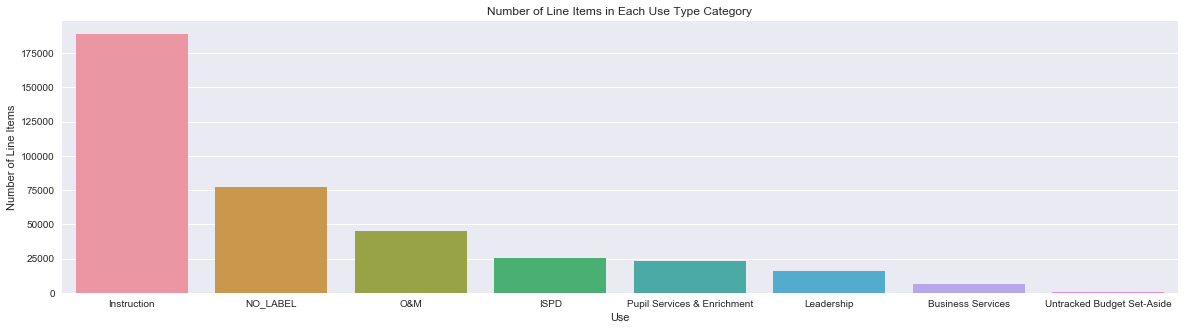

In [6]:
# plot the number of line items in each Use Type category 
plt.figure(figsize=[20, 5])
plt.rcParams.update({'font.size': 26})
sns.countplot(x='Use', data=budget_df, order = budget_df['Use'].value_counts(ascending=False).index)
plt.title('Number of Line Items in Each Use Type Category')
plt.ylabel("Number of Line Items")
plt.show()

The classes appear to be heavily imbalanced, with over half of the line items belonging in the "Instruction" and "No Label" category.

In [7]:
# Inspect Use == 'No Label'
budget_df[budget_df.Use=='NO_LABEL'].head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
1,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,nan,RGN GOB,NaN,UNDESIGNATED,3477.8600,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
10,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,EQUIPMENT *,...,Equipment *,NaN,nan,State and Federal Projects Coordination Services*,NaN,NaN,0.0000,NaN,School to Work,ITEMAI-CITY-YTH EMP & OPP
13,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Regular *,...,Certificated Employees Salaries And Wages,NaN,nan,Disadvantaged Youth *,NaN,NaN,0.0000,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I
14,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,"Operating, Not PreK-12",OTHER PERSONAL SERVICES,...,NaN,CHARTER,0.0000,BASIC (FEFP K-12),NaN,NaN,228.5300,NaN,CONVERSION CHARTER SCHOOLS,NaN
19,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Non-Certificated Travel Reimbursement,...,Travel Mileage/Meeting Expense *,NaN,nan,Instruction And Curriculum Development Services *,NaN,NaN,0.0000,NaN,Special Trust,RESP SEXUAL BEHAVIOR


It is unclear why why some line items would not be labeled. These should be dropped so that they do not interfere with classification.

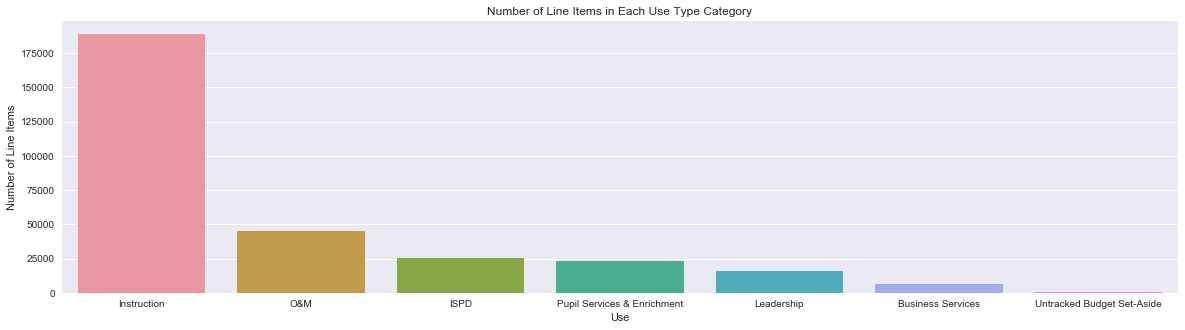

(305692, 25)

In [8]:
budget_df=budget_df[budget_df.Use!='NO_LABEL']

# Plot updated graph
plt.figure(figsize=[20, 5])
plt.rcParams.update({'font.size': 26})
sns.countplot(x='Use', data=budget_df, order = budget_df['Use'].value_counts(ascending=False).index)
plt.title('Number of Line Items in Each Use Type Category')
plt.ylabel("Number of Line Items")
plt.show()

budget_df.shape

Next, I investigate the numeric variables.

(0, 100)

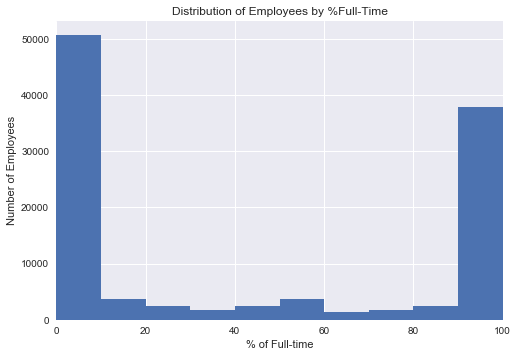

In [9]:
# Histogram of %FTE
plt.hist((budget_df['FTE'].dropna())*100)

# Add title and labels
plt.title('Distribution of Employees by %Full-Time')
plt.xlabel('% of Full-time')
plt.ylabel('Number of Employees')
plt.xlim(0,100)

About 40% of the employees in the data are employed 90% or more full-time. 

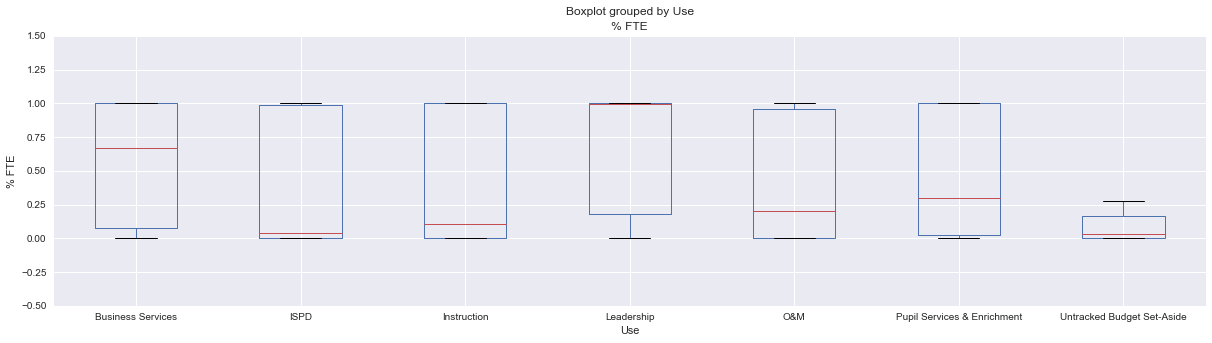

In [10]:
bp=budget_df[['FTE','Use']].dropna()
plt.rcParams.update({'font.size': 10})
bp.boxplot('FTE', by='Use', figsize=(20, 5))
plt.ylim(-.5,1.5)
plt.title("% FTE")
plt.ylabel("% FTE")

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

print(sm.stats.anova_lm(ols('FTE ~ Use', data=budget_df).fit(), typ=2))

C:\Users\ADINA\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


             sum_sq          df        F  PR(>F)
Use        362.3532      6.0000 298.9079  0.0000
Residual 21905.0813 108418.0000      nan     nan


The boxplot above shows that there is considerable variation in the average % of Full Time between employees assigned to different groups. A one-way analysis of variance (ANOVA) test confirms that the average % FTE is statistically significantly different between the different Use groups. This indicates that % FTE may be a good classifier.

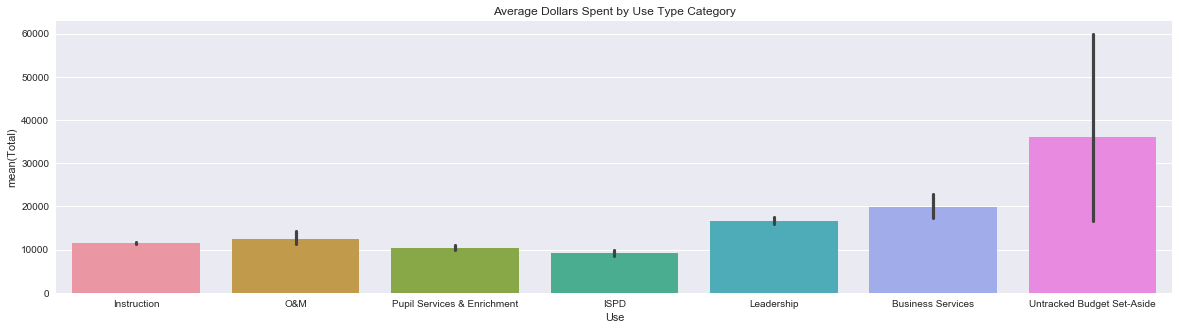

In [12]:
plt.figure(figsize=[20, 5])
sns.barplot(x='Use', y="Total", data=budget_df)
plt.rcParams.update({'font.size': 26})
plt.title('Average Dollars Spent by Use Type Category')
plt.show()

In [13]:
print(sm.stats.anova_lm(ols('Total ~ Use', data=budget_df).fit(), typ=2))

                        sum_sq          df       F  PR(>F)
Use         1251694214294.1257      6.0000 32.5357  0.0000
Residual 1949620788508555.7500 304063.0000     nan     nan


Average spending tends to be relatively similar across different student types, not including the "Alternative" student type and the unclassified line items. A one-way ANOVA test confirms that the average spending is statistically significantly different between two or more groups.

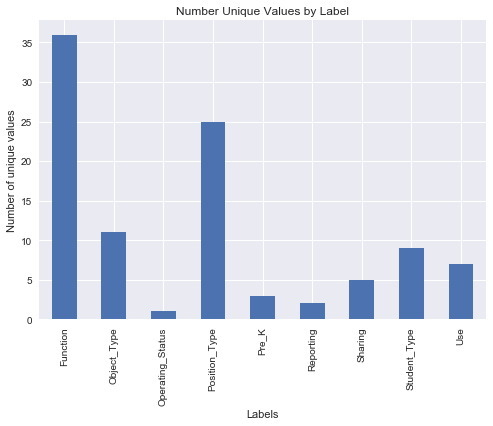

In [14]:
# set lists
LABELS=['Function', 'Object_Type', 'Operating_Status', 'Position_Type','Pre_K', 'Reporting','Sharing','Student_Type','Use']
NUMERIC_COLUMNS=['FTE','Total']
TEXT_COLUMNS = list(set(budget_df.columns.tolist()) - set(LABELS + NUMERIC_COLUMNS))

# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = budget_df[LABELS].apply(pd.Series.nunique)

# Plot number of unique values for each label
num_unique_labels.plot(kind='bar')

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.title('Number Unique Values by Label')

# Display the plot
plt.show()

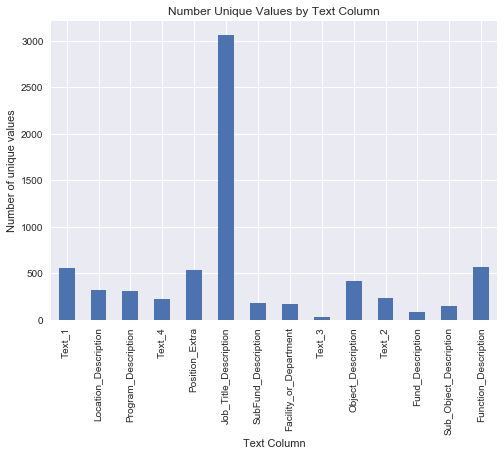

In [15]:
# Calculate number of unique values in each text column: num_unique_labels
num_unique_text = budget_df[TEXT_COLUMNS].apply(pd.Series.nunique)

# Plot number of unique values for each label
num_unique_text.plot(kind='bar')

# Label the axes
plt.xlabel('Text Column')
plt.ylabel('Number of unique values')
plt.title('Number Unique Values by Text Column')

# Display the plot
plt.show()

Our dataset consists almost entirely of free form text columns, with quite a large set of unique values in each column. This text can be transformed into features using a bag-of-words approach and incorporated into our machine learning algorithms.

In the code below, I first combine all text columns into a single text vector to make it easier to extract the features. I use the NLTK 'SnowballStemmer' to stem words to their root so that words like "fishes" and "fish" are considered essentially the same.

In [16]:
# prepare data for natural language processing 
import nltk
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

# Restrict data to just text columns
text_data = budget_df[TEXT_COLUMNS]

# Replace nans with blanks
text_data.fillna("", inplace=True)

# Eliminate punctuation
text_data.replace(to_replace=['[^\w\s]','(blank)'],value=" ", inplace=True, regex=True)

# Join all text items in a row that have a space in between
text_data=text_data.apply(lambda x: " ".join(x), axis=1)

# Apply the stemmer
text_data_stemmed=text_data.apply(lambda x: stemmer.stem(x))

NUMERIC_COLUMNS=['FTE','Total']

# Create the new DataFrame: numeric_data_only
# Fill NA's with -1000 so our models know to treat them differently from 0
numeric_data_only = budget_df[NUMERIC_COLUMNS].fillna(-1000)

# Concatenate the numeric and text columns together
df=pd.concat([numeric_data_only, text_data_stemmed], axis=1)
df.rename(columns={"FTE": "FTE", "Total": "Total", 0: "Text"},inplace=True)

df.head()

C:\Users\ADINA\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\ADINA\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,FTE,Total,Text
0,1.0000,50471.8100,kindergarten kindergarten teacher elementa...
2,1.0000,62237.1300,instruction regular regular instruction te...
3,-1000.0000,22.3000,regular instruction general middle junior hig...
4,-1000.0000,54.1660,regular instruction general high school educa...
5,-1000.0000,0.0000,employee benefits employee benefits undesign...


The next step is to extract numerical features from the now combined text column so that they can be incorporated into our classification model. For this, I use sci-kit learn's TfidfVectorizer. TFIDF stands for Term Frequency - Inverse Document Frequency. Mathematically, TFIDF features are computed using the formula <i>tf(t,d) * idf(t)</i>, where <i>t</i> is the term (i.e., a word), <i>d</i> is the document (i.e., our text column) and <i>tf</i> is the number of occurrences of the term in the document. The <i>idf</i> function is computed as <i>log [ n / df(d, t) ] + 1</i>. Here, <i>n</i> is the total number of documents and <i>df(d,t)</i> is the number of documents that contain the word <i>t</i>. The effect of the idf function is therefore to reduce the weight of words that are more common across line items, which would make classifying a line item item based on distinctive features slightly easier. I also remove all "stop words," i.e. words that are common and don't provide much information (e.g. "he", "and", "the" et cetera) and words that appear in more than 70% of all line items. In addition, I also use the TruncatedSVD function to reduce the dimensions of the TFIDF matrix.

After applying the TFIDF/SVD transformations, I split the data into a training and test set, with the test set being 20% of the original data and the training dataset forming 80% of the data.

In [17]:
# vectorize and split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper

# set the token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Since we are processing both numeric and text features at the same time, use DataFrameMapper to build the pipeline
mapper = DataFrameMapper([
     ('FTE', None),
     ('Total', None),
     ('Text', [TfidfVectorizer(token_pattern=TOKENS_ALPHANUMERIC, max_df=0.7,stop_words='english', ngram_range=(1,2)),
              TruncatedSVD(n_components=100, n_iter=25, random_state=12)]
     )
     ])

features = mapper.fit_transform(df)
labels = budget_df['Use']

# split data, stratify by labels
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, 
                                            random_state=42, stratify=labels)

C:\Users\ADINA\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<b>2. Model Estimation and Evaluation</b>

Now that we have our features ready, we can fit our machine learning classifier. The model I choose to fit is the Random Forest Classifier, which is appropriate for these data because it reduces the risk of overfitting, and is able to quickly and efficiently process sparse matrices associated with text features. A random forest with <i>n</i> trees is created by forming <i>n</i> random samples of size  <i>m</i> from the training data. Each set of random samples consists of  <i>m</i> randomly selected rows. For each set, a decision tree is fit. A random forest performs classification by using a voting method. Each tree in the forest produces a class label and the class label that appears most is taken as the final prediction.

In [25]:
# import relevant modules

import scipy
from random import randint
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.rcParams.update({'font.size': 10})
    plt.figure(figsize=[10, 10])
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def evaluate_features(X, y, X_test, y_test, estimator, param_grid):
    
    # set the classifier
    clf=GridSearchCV(estimator, param_grid, n_jobs=-1,verbose=3, cv=StratifiedKFold(random_state=12))
    # fit the model
    clf.fit(X, y)
    probas = clf.predict_proba(X_test)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y_test)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y_test, probas)))
    print('Accuracy: {}'.format(accuracy_score(y_test, preds)))
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, preds)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes,
                          title='Confusion matrix, without normalization')

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 14.2min finished


Log loss: 0.1754065440978395
Accuracy: 0.9583244737401658
Confusion matrix, without normalization
[[  981    47   105    27    26    37     0]
 [   46  4530   430    28     9    73     1]
 [   26   117 37530    30    26    84     2]
 [  109    81   214  2657    19    43     0]
 [   70    17    81    15  8870    20     2]
 [   46   108   497    28    18  4018     0]
 [    2    31    28     2     2     1     5]]


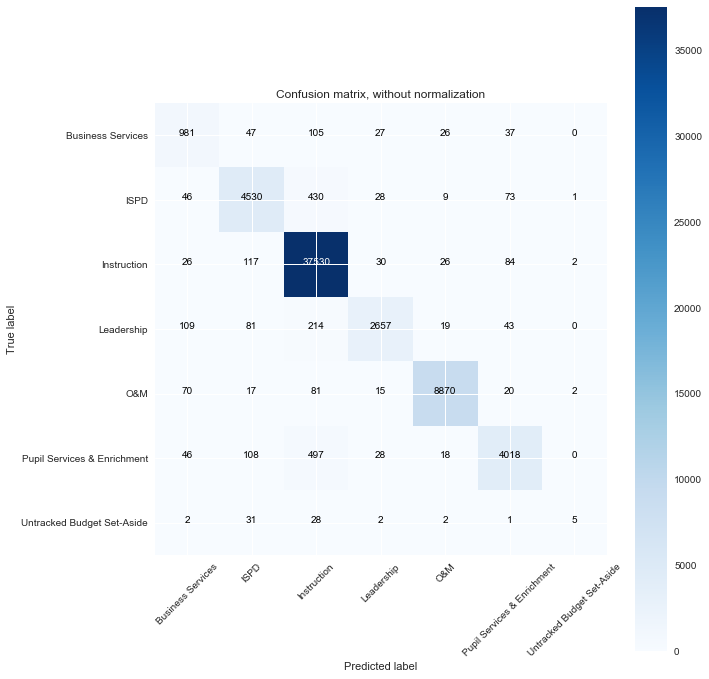

In [26]:
evaluate_features(features_train, labels_train, features_test, labels_test,
                  RandomForestClassifier(),{"n_estimators":[5,10],
                                            "max_depth" : [10,15],
                                            "min_samples_leaf" : [1,6],
                                            "criterion": ["gini", "entropy"],
                                            "random_state": [123]})

To evaluate the success of the classifier, I compute both the accuracy and the log loss metrics. The accuracy of the model is calculated as the number of correct predictions over the total number in the sample. As indicated above, the accuracy of the classifier is about 97%, which means that line items are classified into the correct category about 97% of the time. However, the accuracy can be a slightly inflated measure of success when classes are heavily imbalanced, as is the case with our data. Therefore, I also calculate the log loss, which takes into account the actual uncertainty of the model's prediction based on how much it varies from the actual label. The model is therefore penalized when it confidently predicts an incorrect value for the label - a perfect classifier would have a log loss of zero. As we can see above, our classifier performs remarkably well, with a log loss of only 0.17. It's instructive to note that it doesn't perform nearly as well when trying to classify smaller categories such as "Untracked Budget Set-Aside" - it only classifies it correctly about 50% of the time.

In [103]:
# Next, identify most predictive words for each class
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

vectorizer=TfidfVectorizer(token_pattern=TOKENS_ALPHANUMERIC, max_df=0.7,stop_words='english')
matrix=vectorizer.fit_transform(text_data)

IV = np.zeros((len(vectorizer.vocabulary_)), dtype = object)
for k, v in vectorizer.vocabulary_.items():
    IV[v] = k

labels = list(budget_df.Use.unique())

data=pd.DataFrame()
for i, Ai in enumerate(labels):
    budget_df['flag']=budget_df.Use==Ai
    C = SelectKBest(k = 10)
    C.fit_transform(matrix, budget_df['flag'])
    FR = C.scores_
    df=pd.DataFrame(data={'Word': IV, 'Score': FR})
    df.sort_values('Score', ascending=False, inplace=True)
    df.drop('Score', axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['label']=Ai
    data=data.append(df.head(10))
    
data=data.pivot(columns='label', values='Word')
data.reset_index(drop=True, inplace=True)
data

C:\Users\ADINA\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

C:\Users\ADINA\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.



label,Business Services,ISPD,Instruction,Leadership,O&M,Pupil Services & Enrichment,Untracked Budget Set-Aside
0,systems,staff,teacher,admin,crafts,athletics,unemployment
1,human,dev,instruction,principal,trades,students,tsa
2,technology,facilitator,regular,secretary,transportation,extracurricular,trust
3,computer,leadership,support,administration,food,sports,mycom
4,itemgg,development,education,office,plant,counselor,stance
5,central,curriculum,elementary,administrative,bus,nurse,brick
6,resources,training,transportation,support,service,speech,sol
7,ist,instr,crafts,administrator,operation,psychologist,allcity
8,information,learning,trades,school,driver,guidance,blk
9,accounting,workshop,services,princ,teacher,work,lem


The table above shows the most predictive words for each class. It makes sense that variants of "teacher" and "education" fall under Instruction, whereas variants of "admin" and "principal" fall under leadership.

## Discussion

With the help of machine learning algorithms, ERS can streamline their classification of budget line items more effectively, which would enable them to divert resources to other tasks.